<a href="https://colab.research.google.com/github/AAA123404/Financial-big-data-analysis/blob/main/week9%E4%BD%9C%E6%A5%AD_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install yfinance pandas numpy torch scikit-learn matplotlib

In [32]:
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch.optim as optim
tsmc = yf.download('2330.TW', start='2020-01-01')
tsmc
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_macd(df, fast_period=12, slow_period=26):
    df['EMA12'] = df['Close'].ewm(span=fast_period, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=slow_period, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    return df[['MACD']]


def create_features(df):
  df_feat = df.copy()
  df_feat['MA5'] = df_feat['Close'].rolling(window=5).mean()
  df_feat['MA20'] = df_feat['Close'].rolling(window=20).mean()
  df_feat['RSI'] = calculate_rsi(df_feat['Close'])
  df_feat['MACD'] = calculate_macd(df_feat)['MACD']
  df_feat = df_feat.dropna()
  return df_feat

df_features = create_features(tsmc)
df_features

feature_columns = ['MA5', 'MA20', 'RSI', 'MACD','Open', 'High', 'Low', 'Close']
X = df_features[feature_columns].values
y = df_features['Close'].shift(-1).values[:-1]
X = X[:-1]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(X_scaled) * 0.8)

X_train = X_scaled[:train_size]
X_test = X_scaled[train_size:]
y_train = y_scaled[:train_size]
y_test = y_scaled[train_size:]

[*********************100%***********************]  1 of 1 completed


In [33]:
def create_sequences(X, y, sequence_length=20):
    sequences_X, sequences_y = [], []
    for i in range(len(X) - sequence_length):
        sequences_X.append(X[i:i+sequence_length])
        sequences_y.append(y[i + sequence_length])
    return np.array(sequences_X, dtype=np.float32), np.array(sequences_y, dtype=np.float32)

X_train_seq, y_train_seq = create_sequences(X_train, y_train)
X_test_seq, y_test_seq = create_sequences(X_test, y_test)

X_train_seq = torch.FloatTensor(X_train_seq).float()
y_train_seq = torch.FloatTensor(y_train_seq).float()
X_test_seq = torch.FloatTensor(X_test_seq).float()
y_test_seq = torch.FloatTensor(y_test_seq).float()

class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.float()
        self.y = y.float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_dataset = StockDataset(X_train_seq, y_train_seq)
test_dataset = StockDataset(X_test_seq, y_test_seq)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [34]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model) #(5000,8) #d_model = 輸入的維度，對應 Transformer 模型中的特徵數
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) #(1,5000,8)
        self.register_buffer('pe', pe)

    def forward(self, x): #x(batch_size, seq_len, d_model)
        return x + self.pe[:, :x.size(1)]

In [35]:
class StockTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dropout=0.1):
        super(StockTransformer, self).__init__()

        self.input_projection = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layers = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layers,
            num_layers=num_layers
        )

        self.output_projection = nn.Linear(d_model, 1)

    def forward(self, src):
        src = self.input_projection(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = output[:, -1, :]
        output = self.output_projection(output)

        return output


In [36]:
input_dim = 8
d_model = 64
nhead = 8
num_layers = 3
dropout = 0.1

model = StockTransformer(
    input_dim=input_dim,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dropout=dropout
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [37]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [38]:
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}')

Epoch 5/50
Train Loss: 0.0034
Epoch 10/50
Train Loss: 0.0018
Epoch 15/50
Train Loss: 0.0011
Epoch 20/50
Train Loss: 0.0011
Epoch 25/50
Train Loss: 0.0009
Epoch 30/50
Train Loss: 0.0008
Epoch 35/50
Train Loss: 0.0006
Epoch 40/50
Train Loss: 0.0008
Epoch 45/50
Train Loss: 0.0006
Epoch 50/50
Train Loss: 0.0006


In [39]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    all_predictions = []
    all_targets = []
    test_loss = 0

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.float()
            batch_y = batch_y.float()

            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            test_loss += loss.item()

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())

    avg_loss = test_loss / len(test_loader)
    print(f'Test Loss: {avg_loss:.4f}')

    return np.array(all_predictions), np.array(all_targets)

predictions, targets = evaluate_model(model, test_loader, criterion)

Test Loss: 0.0207


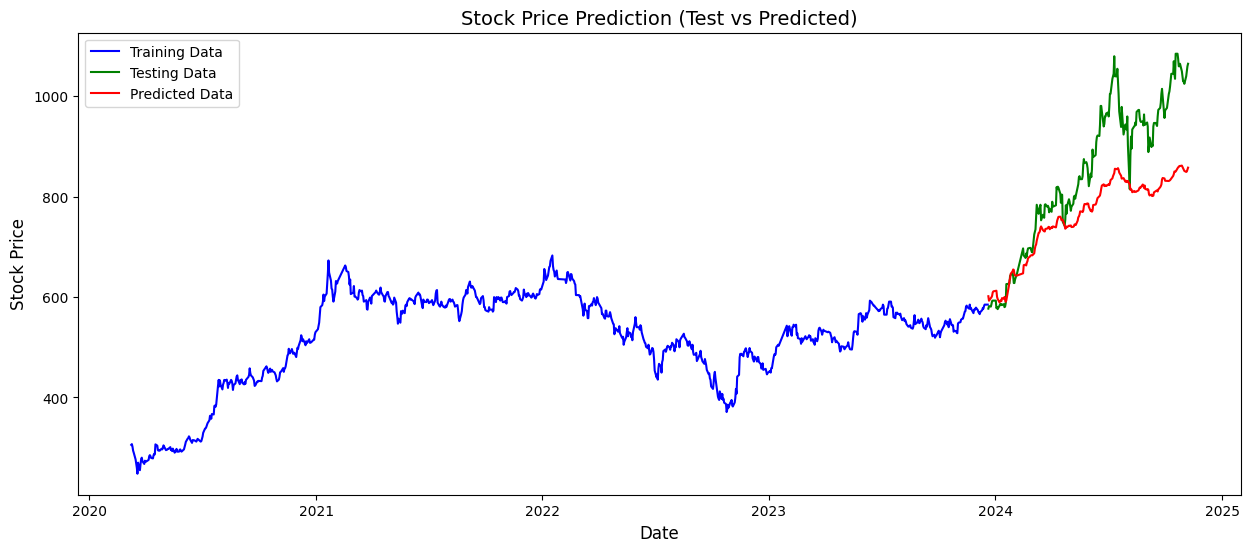

In [41]:
def plot_predictions(df_features, train_size, predictions):
    dates = df_features.index

    train_dates = dates[20:train_size+20]
    test_dates = dates[train_size+20:-1]

    train_data = df_features['Close'][20:train_size+20]
    test_data = df_features['Close'][train_size+20:-1]

    y_pred_actual = scaler_y.inverse_transform(predictions.reshape(-1, 1))

    plt.figure(figsize=(15, 6))

    plt.plot(train_dates, train_data, label='Training Data', color='blue')

    plt.plot(test_dates, test_data, label='Testing Data', color='green')

    pred_dates = test_dates[:]
    plt.plot(pred_dates, y_pred_actual.squeeze(), label='Predicted Data', color='red')
    plt.title('Stock Price Prediction (Test vs Predicted)', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Stock Price', fontsize=12)
    plt.legend()
    plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error
plot_predictions(df_features, train_size, predictions)